In [1]:
import IPython 
%pylab inline
from matplotlib.patches import Circle, Wedge, Polygon

Populating the interactive namespace from numpy and matplotlib


This notebook presents an estimate of the number of positioner collisions per pointing.

The positioner's geometry is defined from the DESIDoc 8999 v2. Images are taken from the same doc.

There are three types of collisions.

1. Type I: No collision.
2. Type II: The two upper arms (fiber holders) collide
3. Type III: The upper arm of A collides with the body of B.


Example of Type 2 collision

Type II collisions requires resetting the target one of the two positioners in order to avoid the overlap.
This collision is equivalent to say that if one the positioners (A) is placed outsed the inner clear rotational envelope, the fiber cannot be closer than $2$ mm to other fiber.


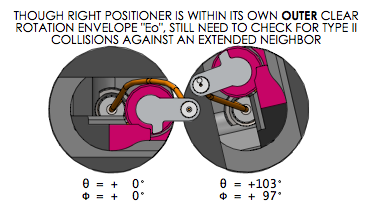

In [2]:
IPython.display.Image("../img/type2_collision.png")

Example of Type 2 collision

For type III collision the condition is less obvious. It will be derived below.

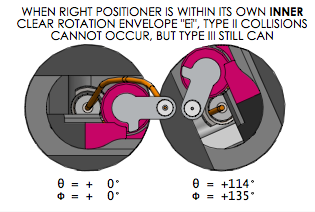

In [3]:
IPython.display.Image("../img/type3_collision.png")

#Deriving simple conditions to check for Type III collisions

In [4]:
lower_holder_radius = 2.0
tip_holder_radius = 1.0
inner_radius = 3.0 # distance from center of the lower part of the ferrule holder
outer_radius = 5.0
arm_length = 3.0 # lenght of the phi arm
dist_between_pos = 0.25

In [5]:
def plot_intersection(frac_max_r=1.0, alpha=0.20, beta_A=2.15, beta_B=-2.68):
    fig = figure(figsize=(10, 10))
    #fig = gcf(figsize=(5,5))
    ax=subplot(aspect='equal')

    circle1=plt.Circle((-outer_radius-0.5*dist_between_pos,0),outer_radius,color='b', alpha=0.5)
    circle2=plt.Circle((outer_radius+0.5*dist_between_pos,0),outer_radius,color='b', alpha=0.5)

    #tip of positioner A
    center_A=(-outer_radius-0.5*dist_between_pos)
    pos_r = frac_max_r* inner_radius+arm_length
    circle3=plt.Circle((pos_r*cos(alpha)+center_A,pos_r*sin(alpha)),tip_holder_radius,color='r', alpha=0.5)


    #bottom part of ferrule holder B
    center_B=outer_radius+0.5*dist_between_pos
    pos_r = inner_radius
    circle4=plt.Circle((pos_r*cos(beta_A)+center_B,pos_r*sin(beta_A)),lower_holder_radius,color='g', alpha=0.5)
    plot([center_B, center_B+outer_radius*cos(beta_A)], [0, outer_radius*sin(beta_A)], color='black')
    
   
    circle6=Wedge((pos_r*cos(beta_A)+center_B,pos_r*sin(beta_A)),arm_length,beta_A*180/pi, 180+beta_A*180/pi, color='orange', alpha=0.4)
    
    #bottom part of ferrule holder B
    center_B=outer_radius+0.5*dist_between_pos
    pos_r = inner_radius
    circle5=plt.Circle((pos_r*cos(beta_B)+center_B,pos_r*sin(beta_B)),lower_holder_radius,color='g', alpha=0.5)
 
    plot([center_B, center_B+outer_radius*cos(beta_B)], [0, outer_radius*sin(beta_B)], color='black')

    circle7=Wedge((pos_r*cos(beta_B)+center_B,pos_r*sin(beta_B)),arm_length,beta_B*180/pi, 180+beta_B*180/pi, color='orange', alpha=0.4)


    

    fig.gca().add_artist(circle1)
    fig.gca().add_artist(circle2)
    fig.gca().add_artist(circle3)
    fig.gca().add_artist(circle4)
    fig.gca().add_artist(circle5)
    fig.gca().add_artist(circle6)
    fig.gca().add_artist(circle7)




    ax.set_xlim((-11,11))
    ax.set_ylim((-5,5))

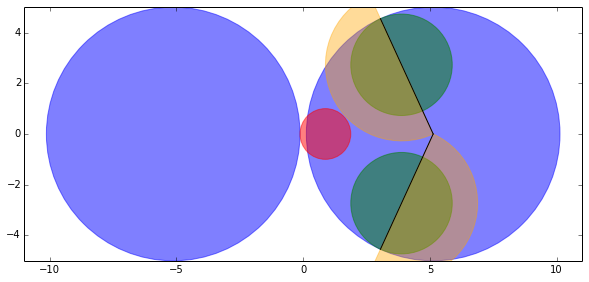

In [56]:
plot_intersection(frac_max_r=1.0, alpha=0.00, beta_A=2.0, beta_B=-2.0)

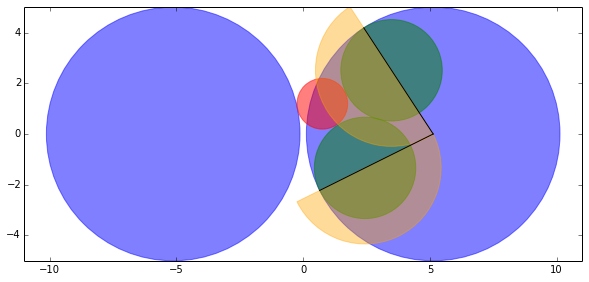

In [57]:
plot_intersection(frac_max_r=1.0, alpha=0.20, beta_A=2.15, beta_B=-2.68)

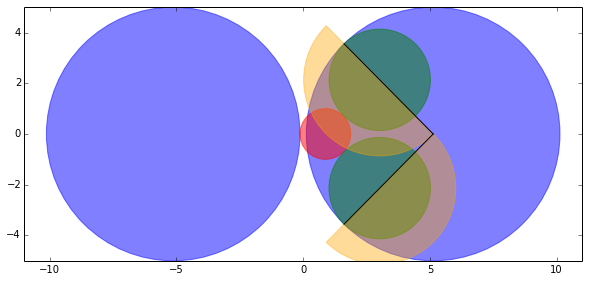

In [58]:
plot_intersection(frac_max_r=1.0,alpha=0.00, beta_A=2.35, beta_B=-2.35)

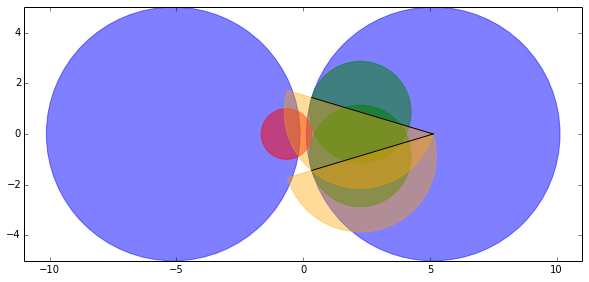

In [59]:
plot_intersection(frac_max_r=0.49, alpha=0.00, beta_A=2.85, beta_B=-2.85)

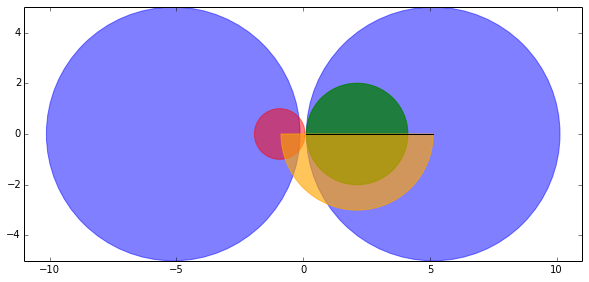

In [60]:
plot_intersection(frac_max_r=0.40, alpha=0.00, beta_A=pi, beta_B=-pi)

To find the angle between the black line and the axis of symmetry we solve a triangle with known sides.

0.783662048798 0.249447377559


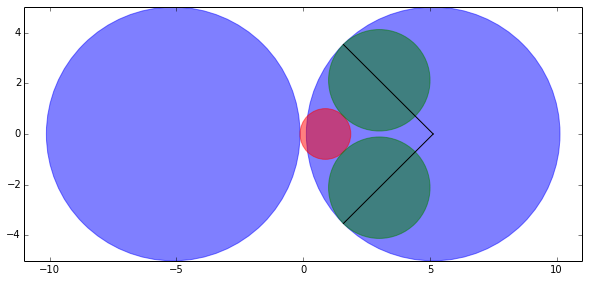

In [163]:
a = inner_radius
b = lower_holder_radius + tip_holder_radius

frac_max_r = 1.0
pos_r = frac_max_r * inner_radius+ arm_length
c = (2.0*outer_radius + dist_between_pos) - pos_r

cos_theta = (a**2 + c**2 - b**2)/(2*b*c)
theta = arccos(cos_theta)
print theta, theta/pi # theta/pi is the fraction of the surface that is lost
plot_intersection(frac_max_r=frac_max_r, alpha=0.00, beta_A=pi-theta, beta_B=pi+theta)

0.993333333333 0.115534300284


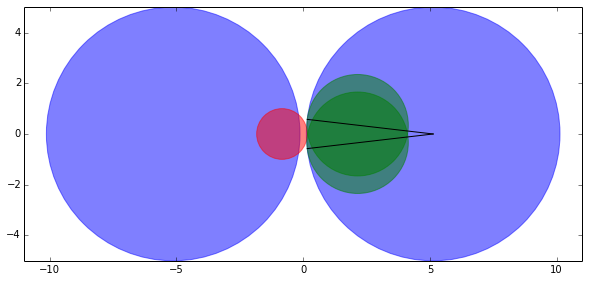

In [164]:
a = inner_radius
b = lower_holder_radius + tip_holder_radius

frac_max_r = 0.43
pos_r = frac_max_r * inner_radius+ arm_length
c = (2.0*outer_radius + dist_between_pos) - pos_r # this is the radius of tip A, with respect to B's center.

cos_theta = (a**2 + c**2 - b**2)/(2*b*c)
theta = arccos(cos_theta)
print cos_theta, theta
plot_intersection(frac_max_r=frac_max_r, alpha=0.00, beta_A=pi-theta, beta_B=pi+theta)

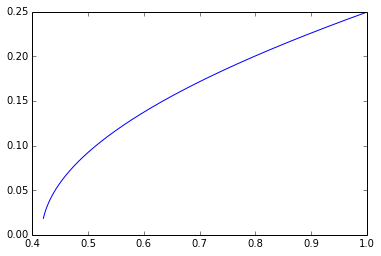

In [165]:
n_points =1000
frac_max_range = linspace(0.42, 1.0, n_points)
theta_range = zeros(n_points)
for i in arange(n_points):
    a = inner_radius
    b = lower_holder_radius + tip_holder_radius

    frac_max_r = 1.0
    pos_r = frac_max_range[i] * inner_radius+ arm_length
    c = (2.0*outer_radius + dist_between_pos) - pos_r

    cos_theta = (a**2 + c**2 - b**2)/(2*b*c)
    theta_range[i] = arccos(cos_theta)

plot(frac_max_range, theta_range/pi) #theta/pi is the fraction of the area that is lost due to the collision

# Test on poissonian targets

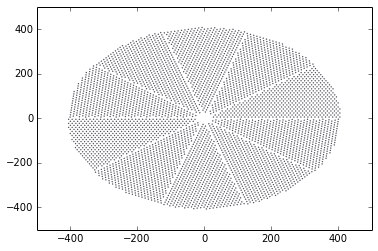

In [4]:
positioner_file = "../../surveyplan/data/pos_on_z1.txt"
positioner_data = loadtxt(positioner_file)
x_pos = positioner_data[:,1]
y_pos = positioner_data[:,2]
z_pos = positioner_data[:,3]
scatter(x_pos, y_pos, s=0.1)
n_pos = size(x_pos)

patrol_radius = 6.0
inner_radius = 5.0 
fiber_radius = 1.0


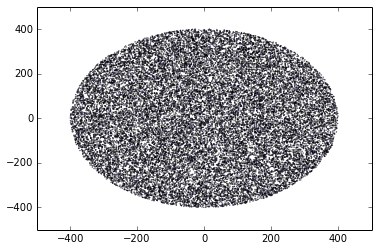

In [14]:
n_targets = n_pos * 5
theta_rand = 2.0*pi*random.random(n_targets)
r_rand = 160000.0*random.random(n_targets)
x_target = sqrt(r_rand) * sin(theta_rand)
y_target = sqrt(r_rand) * cos(theta_rand)
scatter(x_target, y_target, s=0.1)

In [15]:
x_on_target = zeros(n_pos)
y_on_target = zeros(n_pos)
target_available = zeros(n_targets)
for i in range(n_pos):
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    
    distance = sqrt((x_target-x_pos_i)**2 + (y_target - y_pos_i)**2)
    reachable = where((distance<patrol_radius)&(target_available==0))
    reachable = reachable[0]
    n_reachable = size(reachable)
    
    if (n_reachable):
        x_on_target[i] = x_target[reachable[0]]
        y_on_target[i] = y_target[reachable[0]]
        target_available[reachable[0]] = -1
    else:
        x_on_target[i] = x_pos_i
        y_on_target[i] = y_pos_i

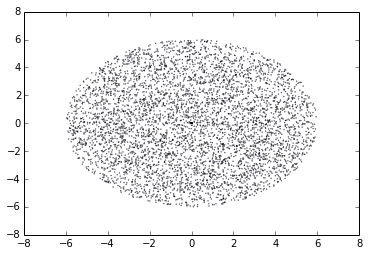

In [16]:
scatter(x_on_target-x_pos, y_on_target-y_pos, s=0.1)

In [17]:
#count how many Type II collisions are happening
possible = 0
collision_id = empty((0), dtype='int')
for i in range(n_pos):
    x_on_t = x_on_target[i]
    y_on_t = y_on_target[i]
    x_pos_i = x_pos[i]
    y_pos_i = y_pos[i]
    
   
    distance = sqrt((x_on_target-x_on_t)**2 + (y_on_target - y_on_t)**2)
    close = where(distance<(2.0*fiber_radius))
    if(size(close)==2):#this indicates that a Type II collision is possible
        collision_id=append(collision_id, close)
list_fiber_collide = sorted(set(collision_id))
print "number of colliding fibers:", size(list_fiber_collide)
print "about %d percent of positioners collide"%(100*size(list_fiber_collide)/n_pos)

number of colliding fibers: 173
about 3 percent of positioners collide


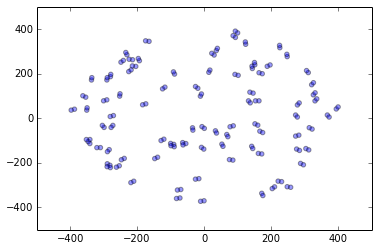

In [18]:
scatter(x_pos[list_fiber_collide], y_pos[list_fiber_collide], alpha=0.4)